## Lithium in Alberta

focus is on the Leduc - Why is that?
https://e3lithium.ca/

In [1]:
import os

import numpy as np
# import matplotlib.cbook as cbook
import pandas as pd

import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

from petro_ninja import PetroNinja

import lithium_data
import load_isopach


Lithium data from the Alberta Geological Survey website, circa 2019/2020

Total of 1634 samples measured, only little more than half have enough info to be used effectively

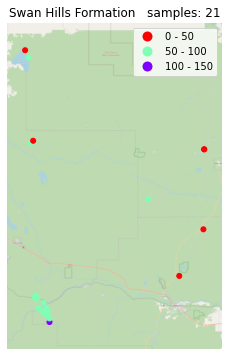

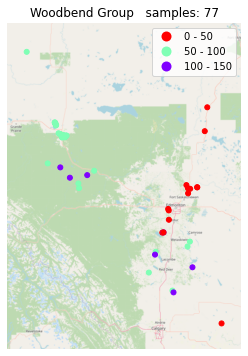

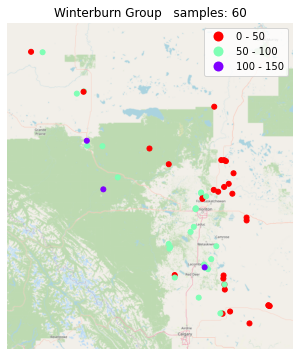

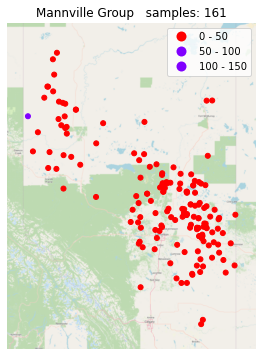

In [2]:

for idx, grp in enumerate(['Swan Hills Formation', 'Woodbend Group', 'Winterburn Group', 'Mannville Group']):

    df = lithium_data.get_lith_horizon(grp)
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Long_NAD83, df.Lat_NAD83))

    # scheme = mc.Quantiles(gdf['Li_mg_L'], k=5)
    scheme = mc.UserDefined(gdf['Li_mg_L'], bins=[50, 100, 150])

    ax = gplt.webmap(gdf, projection=gcrs.WebMercator())
    gplt.pointplot(
        gdf,
        figsize=(8, 6),
        hue='Li_mg_L',
        scheme=scheme,
        legend=True, legend_var='hue', cmap='rainbow_r',
        ax=ax,
    )
    plt.title(grp + "   samples: " + str(len(df)))
    plt.show()

### Geology
A recent research study on the geochemical characteristics of lithium-enriched oilfield brines within Devonian carbonates of the southwestern Alberta Basin shows the presence of at least two brines with distinct chemistry and thus distinct evolutionary histories. 

Lithium-enriched brines of the Swan Hills Formation are thought to have formed by the dissolution of halite and mixing with Li-enriched basement-derived fluids. 

Lithium-enriched brines of the Nisku and Leduc formations are thought to have formed by preferential dissolution of lithium-enriched late-stage evaporite minerals, likely from the middle Devonian Prairie Evaporite, into evapoconcentrated late Devonian seawater.

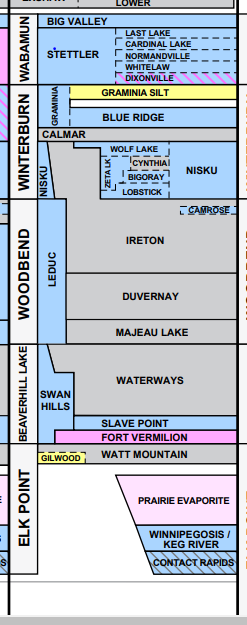

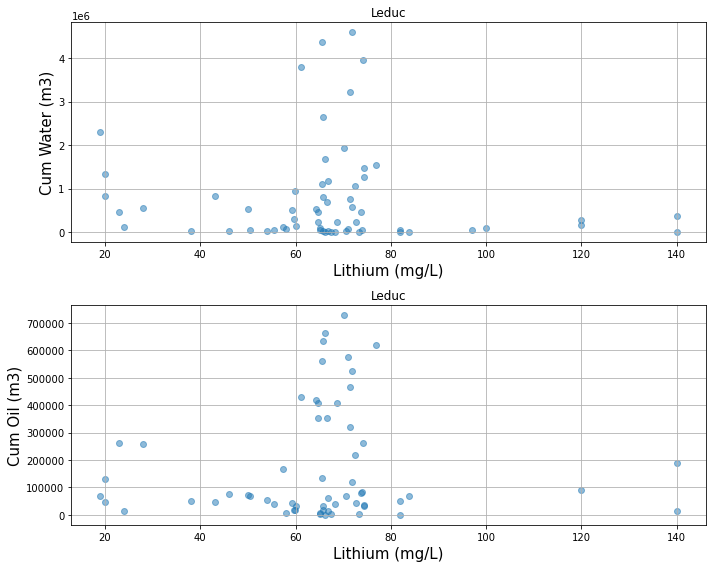

In [6]:

df_woodbend = lithium_data.get_lith_horizon('Woodbend Group')
gdf = gpd.GeoDataFrame(df_woodbend, geometry=gpd.points_from_xy(df_woodbend.Long_NAD83, df_woodbend.Lat_NAD83))
uwi_param = {}

uwi_param['uwis'] = list(gdf['UWI'])

ninja_prod = PetroNinja("wells", "production_summaries")
prod_well_data = ninja_prod.get_wells(uwi_param)
prod_data_df = pd.DataFrame.from_dict(prod_well_data)
prod_data_df = prod_data_df.rename(columns={"wellbore_uwi": "UWI"})

tmp = pd.merge(df_woodbend, prod_data_df, on='UWI', how='outer')
gdf_merge = gpd.GeoDataFrame(tmp, geometry=gpd.points_from_xy(tmp.Long_NAD83, tmp.Lat_NAD83))
gdf_merge['cumulative_water'] = gdf_merge['cumulative_water'].fillna(0)
gdf_merge['cumulative_water'] = gdf_merge['cumulative_water'].astype(float)
# print(gdf_merge['cumulative_water'])

new_data = gdf_merge[gdf_merge['cumulative_water'] > 0]
gdf_merge = gpd.GeoDataFrame(new_data, geometry=gpd.points_from_xy(new_data.Long_NAD83, new_data.Lat_NAD83))

fig, ax = plt.subplots(2, 1)
ax[0].scatter(gdf_merge['Li_mg_L'], gdf_merge['cumulative_water'], alpha=0.5)

ax[0].set_xlabel('Lithium (mg/L)', fontsize=15)
ax[0].set_ylabel('Cum Water (m3)', fontsize=15)
ax[0].set_title('Leduc')

ax[0].grid(True)

ax[1].scatter(gdf_merge['Li_mg_L'], gdf_merge['cumulative_oil'], alpha=0.5)

ax[1].set_xlabel('Lithium (mg/L)', fontsize=15)
ax[1].set_ylabel('Cum Oil (m3)', fontsize=15)
ax[1].set_title('Leduc')

ax[1].grid(True)
fig.tight_layout()

plt.show()


In [7]:
df = load_isopach.clean_isopach()
proj_coords, grid = load_isopach.grid_isopach(df)


         longitude     latitude    elevation
count  2222.000000  2222.000000  2222.000000
mean   -112.966458    53.791687  -766.082074
std       5.967524     3.539690   684.202800
min    -123.250566    49.003157 -3497.558594
25%    -117.842477    50.629157 -1067.889557
50%    -113.664501    52.993728  -599.546234
75%    -108.294262    56.887704  -283.143318
max     -99.745320    61.160016   228.149185
(array([-7431170.63153398, -7415458.38726032, -7399743.77707884, ...,
       -8027910.88169415, -8006886.594417  , -8052291.75950401]), array([3703629.58189271, 3704000.62008881, 3704317.75615654, ...,
       5088672.09906314, 5091921.58250132, 5106236.60170592]))
Gridder used: ScipyGridder()
Data region: (-123.2505657, -99.74531979, 49.00315652, 61.16001605)
Generated geographic grid: <xarray.Dataset>
Dimensions:    (latitude: 147, longitude: 283)
Coordinates:
  * longitude  (longitude) float64 -123.3 -123.2 -123.1 ... -99.91 -99.83 -99.75
  * latitude   (latitude) float64 49.0 49.09 49.

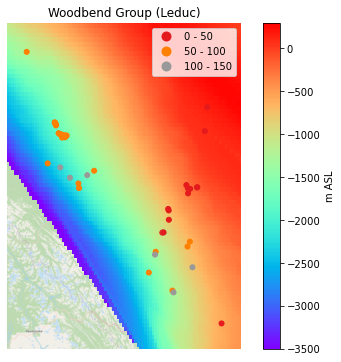

In [8]:

df = lithium_data.get_lith_horizon('Woodbend Group')
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Long_NAD83, df.Lat_NAD83))

# scheme = mc.Quantiles(gdf['Li_mg_L'], k=5)
scheme = mc.UserDefined(gdf['Li_mg_L'], bins=[50, 100, 150])

crs = ccrs.PlateCarree()
ax = gplt.webmap(gdf, projection=gcrs.WebMercator())
gplt.pointplot(
    gdf,
    hue='Li_mg_L',
    scheme=scheme,
    legend=True, legend_var='hue', cmap='Set1',
    ax=ax
)

pc = grid.elevation.plot.pcolormesh(
    ax=ax, transform=crs, zorder=-1, add_colorbar=False,
    vmin=-3500, vmax=300, cmap='rainbow',
)
plt.colorbar(pc).set_label("m ASL")

plt.title('Woodbend Group (Leduc)')

# plt.xlabel("Longitude")
# plt.ylabel("Latitude")

plt.show()
